In [43]:
import pandas as pd
import numpy as np

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
import keras
from keras import layers

In [44]:
train_feature_df = pd.read_csv("fuse_data_train.csv")
val_feature_df = pd.read_csv("fuse_data_val.csv")

In [45]:
# net feature 0-199
# shape 49
# shape 52
train_features = train_feature_df.copy()
train_labels = train_features.pop('class')

val_features = val_feature_df.copy()
val_labels = val_features.pop('class')

In [46]:
from sklearn.preprocessing import StandardScaler
x_train = train_features.values
x_train = StandardScaler().fit_transform(x_train) # normalizing the features
x_val = val_features.values
x_val = StandardScaler().fit_transform(x_val) # normalizing the features

train_features_norm = pd.DataFrame(x_train,columns=train_features.columns)
val_features_norm = pd.DataFrame(x_val,columns=val_features.columns)

In [47]:
from sklearn.decomposition import PCA
component_count = 200
pca_features = PCA(n_components=component_count)
principal_components_train = pca_features.fit_transform(x_train)
principal_components_val = pca_features.fit_transform(x_val)

In [48]:
print('Explained variation per principal component: {}'.format(pca_features.explained_variance_ratio_))
np.sum(pca_features.explained_variance_ratio_)

principal_components_train = pd.DataFrame(data = principal_components_train, columns=[f"pca_{idx}" for idx in range(component_count)])
principal_components_val = pd.DataFrame(data = principal_components_val, columns=[f"pca_{idx}" for idx in range(component_count)])

Explained variation per principal component: [0.118 0.087 0.079 0.054 0.05  0.041 0.037 0.029 0.026 0.025 0.023 0.022
 0.019 0.018 0.016 0.015 0.014 0.013 0.013 0.012 0.012 0.011 0.01  0.01
 0.01  0.009 0.009 0.009 0.008 0.008 0.008 0.008 0.008 0.008 0.008 0.007
 0.007 0.007 0.007 0.006 0.006 0.006 0.006 0.005 0.005 0.005 0.005 0.004
 0.004 0.004 0.004 0.004 0.004 0.003 0.003 0.003 0.003 0.003 0.002 0.002
 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    

In [49]:
print(principal_components_train.shape, principal_components_val.shape)

(228830, 200) (1495, 200)


In [50]:
# test_features_dict = {name:values[:1] for name, values in features_dict.items()}
# feature_preprocessing(test_features_dict)

In [51]:
normalizer = keras.layers.Normalization(axis=-1)
normalizer.adapt(principal_components_train.values)
encoding = keras.layers.CategoryEncoding(num_tokens=3, output_mode="one_hot")

def construct_model(learning_rate=0.005):
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"), 
        layers.Dense(3, activation="relu"),
    ])

  # preprocessed_inputs = preprocessing_head(inputs)
  # result = body

    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
      loss=keras.losses.BinaryCrossentropy(from_logits=True),
      metrics=[keras.metrics.CategoricalAccuracy()],
    )
    return model

In [52]:
base_epochs = 10
train_labels_1ht = encoding(train_labels)
val_labels_1ht = encoding(val_labels)

In [63]:
fusion_model = construct_model(learning_rate=1e-5)
train_history = fusion_model.fit(x=train_features_norm, y=train_labels_1ht, epochs=20, validation_data=(val_features_norm, val_labels_1ht))

Epoch 1/20
7151/7151 ━━━━━━━━━━━━━━━━━━━━ 4s 507us/step - categorical_accuracy: 0.4341 - loss: 0.6995 - val_categorical_accuracy: 0.6161 - val_loss: 0.6603
Epoch 2/20
7151/7151 ━━━━━━━━━━━━━━━━━━━━ 4s 518us/step - categorical_accuracy: 0.6078 - loss: 0.6605 - val_categorical_accuracy: 0.6662 - val_loss: 0.6513
Epoch 3/20
7151/7151 ━━━━━━━━━━━━━━━━━━━━ 4s 504us/step - categorical_accuracy: 0.6356 - loss: 0.6552 - val_categorical_accuracy: 0.6769 - val_loss: 0.6480
Epoch 4/20
7151/7151 ━━━━━━━━━━━━━━━━━━━━ 4s 518us/step - categorical_accuracy: 0.6454 - loss: 0.6530 - val_categorical_accuracy: 0.6849 - val_loss: 0.6454
Epoch 5/20
7151/7151 ━━━━━━━━━━━━━━━━━━━━ 4s 513us/step - categorical_accuracy: 0.6517 - loss: 0.6506 - val_categorical_accuracy: 0.6903 - val_loss: 0.6421
Epoch 6/20
7151/7151 ━━━━━━━━━━━━━━━━━━━━ 4s 517us/step - categorical_accuracy: 0.6588 - loss: 0.6463 - val_categorical_accuracy: 0.6930 - val_loss: 0.6399
Epoch 7/20
7151/7151 ━━━━━━━━━━━━━━━━━━━━ 4s 515us/step - catego

In [59]:
# fusion_model.save("data/FusionNetwork2.h5")
fusion_model.save_weights("data/FusionWeights.weights.h5", overwrite=True)
keras.saving.save_model(fusion_model, 'data/FusionNetwork2.keras')

acc = train_history.history['categorical_accuracy']
val_acc = train_history.history['val_categorical_accuracy']

loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

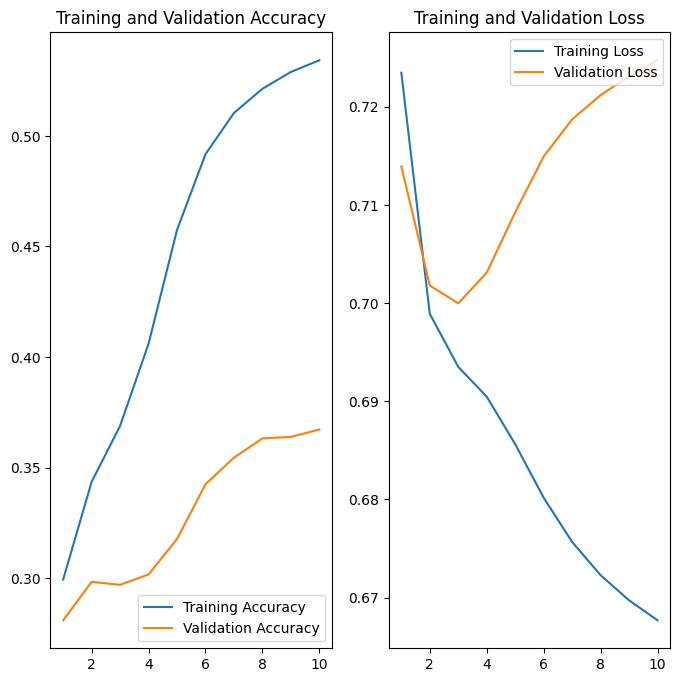

In [55]:
import matplotlib.pyplot as plt
epochs_range = range(1, 11)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [56]:
# fusion_model_fine = keras.models.load_model('data/FusionNetwork.keras')
fusion_model_fine = construct_model()
fusion_model_fine.load_weights("data/FusionWeights.weights.h5")


NameError: name 'feature_preprocessing' is not defined

In [ ]:
total_epochs = base_epochs

for rate in [5e-6, 2e-6, 1e-6]:
    total_epochs += 10
    fusion_model_fine.compile(
            optimizer=keras.optimizers.Adam(learning_rate=rate),
            loss=keras.losses.BinaryCrossentropy(from_logits=True),
            metrics=[keras.metrics.CategoricalAccuracy()],
        )
    train_history = fusion_model_fine.fit(x=train_features_dict, y=train_labels, validation_data=(val_features_dict, val_labels),
                             epochs=total_epochs,
                             initial_epoch=train_history.epoch[-1])
    
    acc += train_history.history['categorical_accuracy']
    val_acc += train_history.history['val_categorical_accuracy']
    
    loss += train_history.history['loss']
    val_loss += train_history.history['val_loss']

In [ ]:
for rate in [5e-7, 2e-7]:
    total_epochs += 10
    fusion_model_fine.compile(
            optimizer=keras.optimizers.Adam(learning_rate=rate),
            loss=keras.losses.BinaryCrossentropy(from_logits=True),
            metrics=[keras.metrics.CategoricalAccuracy()],
        )
    train_history = fusion_model_fine.fit(x=train_features_dict, y=train_labels, validation_data=(val_features_dict, val_labels),
                             epochs=total_epochs,
                             initial_epoch=train_history.epoch[-1])
    
    acc += train_history.history['categorical_accuracy']
    val_acc += train_history.history['val_categorical_accuracy']
    
    loss += train_history.history['loss']
    val_loss += train_history.history['val_loss']